# Проект: Прогнозирование роста заболеваемости COVID 19.
Выполнил: Запсельский Виктор

Проверили: Еремеев Иван, 
Чиркина Дарья ,
Евгений Бокарев

# Import lib

In [ ]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

import sqlite3
con = sqlite3.connect(':memory:')

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return str(name)

def select(sql, data):
    for data_ in data: 
        data_.to_sql(get_df_name(data_), con, index = False, if_exists= 'replace')
    return pd.read_sql(sql, con)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Introduction

В качестве курсового проекта мной была выбрана тема: Прогнозирование временных рядов. </br>
***Данные для прогноза:*** [COVID 19](https://www.kaggle.com/c/covid19-global-forecasting-week-4/data?select=train.csv) </br>
***Описание данных:*** </br>
- датасет содержит информацио о распространении короновирусной инфекции за 4 месяца от 2020-01-22 до 2020-05-15
- столбец Country_Region - название страны
- столбец Province_State - штат/провинция. Есть значения Nan. У одной страны может быть несколько штатов.
- столбец ConfirmedCases - общее кол-во подтвержденных случаев по штату/провинции. Если в Province_State - значение Nan, то ConfirmedCases рассчитывается по Country_Region.
- столбец Fatalities - общее кол-во смертей по штату/провинции. Если в Province_State - значение Nan, то Fatalities рассчитывается по Country_Region.</br>

***Актуальность выбранной темы:***</br>
Думаю для всего мира на 2021 год проблема распространения COVID-19 является одной из главных проблем. Из-за большой заболеваемости в мире в 2019 году страны были вынуждены вводить локдауны по всему миру, экономика мира терпела убытки и, безусловно, хотелось бы “сгладить” убытки. Поэтому, чтобы не допустить неожиданных результатов развития заболеваемости было бы хорошо знать динамику распространения заболевания на ближайшее будущее.

Лично для меня предсказание временных рядов является очень интересной задачей, так как я воспринимаю это как некоторое “соревнование”: в ходе решения задачи нужно уметь выбирать правильную модель для конкретного случая, правильно её оптимизировать и улучшать качество модели по выбранным метрикам с каждым baseline’ом. А участвовать в соревнованиях и побеждать я люблю с детства : )

***Какие практические вопросы были исследованны в ходе работы ?***</br>
1) Был проведён первичный анализ данных: </br>
- построены графики заражений/ сметрности в день и за всё время для ТОП 5 стран, имеющие самый большой показатель заражение. Сделаны выводы по темпу распространения короновируса в этих странах.</br>
- Используя библиотеку geopy, были получены координаты для каждой страны и после с помощью модуля keplergl данные были визуализированы на карте</br>

2) Реализованы две модели предсказания временных рядов, а также выволнен подбор гиперпараметров для каждой из модели.:</br>
- 1-ая с помощью библиотеки facebook.Prophet (модель Prophet)</br>
-2-ая с помощью библиотеки statsmodels (модель Arima)</br>

3) Используя данные модели, выполнен прогноз для: 
- кол-ва заражений/смертей в день по миру;
- кол-ва заражений/смертей за всё время по миру;
- кол-ва заражений/смертей в день по России;
- кол-ва заражений/смертей за всё время по России;</br>

4) Сделана визуализация данных для полученного прогноза</br>

5) Проведено сравнение двух моделей для конкретных случаев

***Схема исследования***:</br><center>
<img src="https://ie.wampi.ru/2021/12/22/Untitled-8.jpg" alt="Untitled (8)" border="0" width = 3000></center>

In [ ]:
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-py3-none-any.whl size=7845 sha256=bca7daef75e1bc71201dd8ddfaa84e4716756f7c43d2113ed5ae046a7d254151
  Stored in directory: /root/.cache/pip/wheels/56/41/5b/0c6d42b3604a5c823d8922564c4708f84962fa7f2f4facfa6d
Successfully built ml-metrics


# Import and agregate data

## Description:

Импортируем данные и агрегируем их в три таблицы (total_by_country, df_by_state, df_by_country), используя sqllite. <br>
Далее, используя таблицу total_by_country и библиотеки geopy, keplergl визуализируем данные на карте.

***Описание таблиц:***

**1) total_by_country** - таблица с суммарными значениями кол-ва заболевших/смертей по каждой стране:<br>
Country_Region - название страны:<br>
total_ConfirmedCases - суммарное кол-во заболевших в стране:<br>
total_Fatalities - суммарное кол-во смертей в стране:<br>

**2) df_by_state** - таблица с данными по каждому штату:<br>
Province_State,Country_Region,Date,ConfirmedCases,Fatalities - название штата, страны, дата, кол-во заражений по штату (учитывая кол-во предыдущих дней),кол-во смертей по штату (учитывая кол-во предыдущих дней) 
Fatalities_per_day - кол-во смертей по штату в день<br>
ConfirmedCases_per_day - кол-во заражений по штату в день<br>

**3) df_by_country** - таблица с данными агрегированными по каждой стране:<br>
Province_State,Country_Region,Date,ConfirmedCases,Fatalities - название штата, страны, дата, кол-во заражений по штату (учитывая кол-во предыдущих дней),кол-во смертей по штату (учитывая кол-во предыдущих дней) <br>
FPD_by_countr - кол-во смертей по стране в день	<br>
CPD_by_countr - кол-во заражений по стране в день	<br>
F_by_countr	- кол-во смертей по стране (учитывая кол-во предыдущих дней)<br>
C_by_countr - кол-во заражений по стране (учитывая кол-во предыдущих дней)<br>

## Code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/train.csv")

In [ ]:
#my_data
sql = '''
SELECT *, SUM(Fatalities_per_day) as FPD_by_countr, SUM(ConfirmedCases_per_day) as CPD_by_countr,
SUM(Fatalities) as F_by_countr, SUM(ConfirmedCases) as C_by_countr FROM df_by_state
GROUP BY  Country_Region , Date
'''

total_by_country = pd.read_csv("/content/drive/MyDrive/total_by_country.csv", error_bad_lines=False, sep= '\t')
df_by_state = pd.read_csv("/content/drive/MyDrive/by_state.csv", error_bad_lines=False, sep= '\t')
df_by_country = pd.DataFrame(select(sql, [df_by_state]))

In [ ]:
def transform_data(df):
  df.columns = ['ds', 'y']
  df.ds = pd.to_datetime(df.ds)
  return df

RUSSIA = df_by_country[df_by_country['Country_Region']=='Russia']
RUSSIA = RUSSIA[['Date','CPD_by_countr','FPD_by_countr','C_by_countr','F_by_countr']]
RUSSIA_CPD = transform_data(RUSSIA[['Date','CPD_by_countr']])
RUSSIA_FPD = transform_data(RUSSIA[['Date','FPD_by_countr']])
RUSSIA_C = transform_data(RUSSIA[['Date','C_by_countr']])
RUSSIA_F = transform_data(RUSSIA[['Date','F_by_countr']])

In [ ]:
sql = '''
SELECT Date , SUM(CPD_by_countr) as CPD_total , SUM(FPD_by_countr) as FPD_total , SUM(C_by_countr) AS C_total , SUM(F_by_countr) AS F_total
FROM df_by_country
GROUP BY Date
'''

TOTAL = pd.DataFrame(select(sql, [df_by_country]))
TOTAL_CPD = transform_data(TOTAL[['Date','CPD_total']])
TOTAL_FPD = transform_data(TOTAL[['Date','FPD_total']])
TOTAL_C = transform_data(TOTAL[['Date','C_total']])
TOTAL_F = transform_data(TOTAL[['Date','F_total']])

# EDA and visualizate data on  map

## Description:

Проведём первичный анализ данных. Для этого из таблицы df_by_country выделим 5 стран с самым большим показателем кол-ва заболевших за всё время.<br>
ТОП 5 стран с max confirmed cases:<br>
1) US<br>
2) Russia<br>
3) UK<br>
4) Italy<br>
5) Spain<br>
Дальше построим графики зависимости ConfirmedCases/Fatalities per day and Total cases/Total fatalities.

## EDA:

Выделим ТОП 5 стран по наибольшему показателю заболеваемости. И посмотрим на динамику роста заболеваемости в этих странах.

In [ ]:
RUSSIA = df_by_country[df_by_country['Country_Region'] == 'Russia']
SPAIN  = df_by_country[df_by_country['Country_Region'] == 'Spain']
UK = df_by_country[df_by_country['Country_Region'] == 'United Kingdom']
ITALY = df_by_country[df_by_country['Country_Region'] == 'Italy']
US = df_by_country[df_by_country['Country_Region'] == 'US']

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_by_country.Date, y=RUSSIA.CPD_by_countr, name='RUSSIA'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=UK.CPD_by_countr, name='UK'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=SPAIN.CPD_by_countr, name='SPAIN'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=ITALY.CPD_by_countr, name='ITALY'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=US.CPD_by_countr, name='US'))
fig.update_layout(title_text='ConfirmedCases per day by TOP 5 country',legend_orientation="h",xaxis_title="days",
                  yaxis_title="ConfirmedCases per day")

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_by_country.Date, y=RUSSIA.FPD_by_countr, name='RUSSIA'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=UK.FPD_by_countr, name='UK'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=SPAIN.FPD_by_countr, name='SPAIN'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=ITALY.FPD_by_countr, name='ITALY'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=US.FPD_by_countr, name='US'))
fig.update_layout(title_text='Fatalities per day by TOP 5 country',legend_orientation="h",xaxis_title="days",
                  yaxis_title="Fatalities per day")

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_by_country.Date, y=RUSSIA.C_by_countr, name='RUSSIA'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=UK.C_by_countr, name='UK'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=SPAIN.C_by_countr, name='SPAIN'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=ITALY.C_by_countr, name='ITALY'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=US.C_by_countr, name='US'))
fig.update_layout(title_text='Total confirmed cases by TOP 5 country',legend_orientation="h",xaxis_title="days",
                  yaxis_title="Total confirmed cases ")

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_by_country.Date, y=RUSSIA.F_by_countr, name='RUSSIA'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=UK.F_by_countr, name='UK'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=SPAIN.F_by_countr, name='SPAIN'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=ITALY.F_by_countr, name='ITALY'))
fig.add_trace(go.Scatter(x=df_by_country.Date, y=US.F_by_countr, name='US'))
fig.update_layout(title_text='Total fatalities by TOP 5 country',legend_orientation="h",xaxis_title="days",
                  yaxis_title="Total fatalities")

fig.show()

## Visualizate data on map

Используя библиотеку geopy добавим в талблицу total_by_country коррдинаты стран.

 После чего с помошью библиотеки keplergl выполним визуализацию данных на карте. 
 
Использовав различные фильтры в настройках, можно интерактивно отследить динамику развития заболевания.

In [ ]:
#!pip install geopy
!pip install keplergl
from geopy.geocoders import Nominatim
from google.colab import output
output.enable_custom_widget_manager()
from google.colab import output
output.disable_custom_widget_manager()
from keplergl import KeplerGl
from tqdm import tqdm

In [ ]:
#append coord
latitude = []
longitude = []
for i in tqdm(range(len(total_by_country))):
    loc = '{}'.format(total_by_country.Country_Region[i])
    geolocator = Nominatim(user_agent="my_request", timeout=5)
    location = geolocator.geocode(loc)
    latitude.append(location.latitude)
    longitude.append(location.longitude)

100%|██████████| 184/184 [01:31<00:00,  2.00it/s]


In [ ]:
coord = pd.DataFrame({'latitude':latitude, 'longitude':longitude})
total_by_country =total_by_country.join(coord)

In [ ]:
config = {
'version': 'v1',
'config': {
    'mapState': {
        'latitude': 37.76209132041332,
        'longitude': -122.42590232651203,
        'zoom': 12.32053899007826
    }

}}
map_1 = KeplerGl(height = 700)
map_1.add_data(data=total_by_country, name='Country_Region')
map_1.config = config
map_1.show()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


<IPython.core.display.Javascript object>

## Conclussion to EDA:

- США вышли на первое место по показателю кол-ва заражений в день с 21 марта 
- Россия вышла на второе место по показателю кол-ва заражений в день с 19 апреля
- максимальный показатель смертей в день был зафиксирован в США 16 апреля и составил 4591
- Россия ~ c 12 мая на втором месте по общему кол-ву заражений

Интересно, что кол-во смертей в день в России очень низкое по сравнению с другими странами. Хотя, как было сказано выше, Россия - на втором месте по кол-ву заражений в день и на втором месте по общему числу заболевших.<br>
Наверное, Россияне самый живучий народ :)<br>
  Так, в России:
  - кол-во смертей за всё время: ~2400 человек
  - кол-во заражений за всё время: ~260k человек<br>
В Англии:
  - кол-во смертей за всё время: ~35000 человек
  - кол-во заражений за всё время: ~230k человек

# Model: Arima

## Intro 

Теперь приступим к созданию моделей.Первая модель предсказаний - модель ***ARIMA (Autoregressive Integrated Moving Average)***.
Эта модель требует выполнения ряда условий, в отличие от модели Prophet.

Во-первых, ряд должен быть стационарным. В случае, если ряд не стационарный, то необходимо либо стабилизировать дисперсию, используя преобразование Бокса-Кокса, либо продиффиринцировать данный ряд d раз. Обычно d < 2, т.к. диффиринцирование более высоких порядков будет давать искаженный результат. Для проверки стационарности будем использовать тест Дики-Фуллера. Он проверяет ряд на наличие так называемых единичных корней. В случае отсутвия единичных корней ряд будет являться стационарным.

Во-вторых, необходимо вручную подбирать гиперпараметры. В отличие от модели Prophet, что замедляет процесс построения модели.

**Основные компоненты модели (p,d,q):**

**AR (Autoregressive)** - компонента авторегрессии (p). Для нахождения данного параметра будем использовать Plot the autocorrelation function (plot_acf) из библиотеки statmodels. В параметрах plot_acf передаём кол-во лагов на графике, после чего смотрим на plot и считаем колличество лагов, которые имеют высокую корреляцию. Кол-во таких лагов = p.

**I (Integrated)** - компанента интегрирования (d). Выбор данного параметра будем производить используя тест Дики-Фуллера. Значение параметра зависит от того, сколько раз необходимо продиффиринцировать ряд для того, чтобы он принял стационарный вид. В случае, если ряд уже стационарный, то d = 0 и модель будет называться ARMA.

**MA (Moving Average)** - компонента скользящего среднего. Для нахождения данного параметра будем использовать Plot the partial autocorrelation function (plot_pacf) из библиотеки statmodels (график частичной автокорреляции). Подбор данного параметра аналогчен параметру p. В параметрах plot_pacf передаём кол-во лагов на графике, после чего смотрим на plot и считаем колличество лагов, которые имеют высокую корреляцию. Кол-во таких лагов = q.

***Описание функций:***

stationarity(ts)- проверка ряда на стационарность с использованием теста Дики-Фуллера.

corr(ts) - графики автокорреляции и частичной корреляции.

visualize_predictions(df,days,pred_arima,pred_prophet,title,xaxis_title,yaxis_title) - визуализация результатов теста для двух моделей

arima(df,windows) - модель предсказаний Arima

Пару слов о реализации модели предсказаний Arima:

1) Формируются массивы mae = [] and mape = []

2) Для каждого дня из массива windows выбираются наилучшие значения p,d,q, вычисляется предсказание, считается mae and mape

3) Результат записывается в заданные массивы mae and mape

4) Функция возвращает прогноз и 2 массивы с ошибками ( mae , mape), вычисленными для каждого из дней в массиве windows

Нагляднее работа функции показана на схеме ниже.

<img src="https://ie.wampi.ru/2021/12/22/Untitled-12.jpg" alt="Untitled (12)" border="0">

## Code

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import ml_metrics as metrics

In [ ]:

def split(df):
    #splitting 85%/15% because of little amount of data
    size = int(len(df) * 0.85)
    train= df[:size]
    test = df[size:]
    return(train,test)

import tqdm
#Arima modeling for ts
def arima(df,windows):
    mae = []
    mape = []
    for window in windows:
      size = int(len(df) * window)
      train= df[:size]
      test = df[size:]
      p=d=q=range(0,6)
      a=99999
      pdq=list(itertools.product(p,d,q))
      
      #Determining the best parameters
      for var in pdq:
          try:
              model = ARIMA(train, order=var)
              result = model.fit()

              if (result.aic<=a) :
                  a=result.aic
                  param=var
          except:
              continue
              
      #Modeling
      model = ARIMA(train, order=param)
      result = model.fit()
      pred=result.forecast(steps=len(test))[0]
      
      print('Mean absolute error: %f'%metrics.mae(test,pred))
      print('Mean absolute percent error: %f'%mean_absolute_percentage_error(test,pred))

      mae.append(metrics.mae(test,pred))
      mape.append((mean_absolute_percentage_error(test,pred)*100))
    return pred , mae , mape , test


In [ ]:
def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)

In [ ]:
def corr(ts):
    plot_acf(ts,lags=12,title="ACF")
    plot_pacf(ts,lags=12,title="PACF")

Разложим наши ряды для России на составляющие: тренд, сезонность и остатки.

Decomposition of RUSSIA_CPD


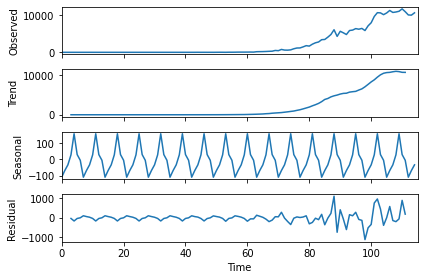

In [ ]:
print('Decomposition of RUSSIA_CPD')
fig=sm.tsa.seasonal_decompose(RUSSIA_CPD.y.values,freq=7).plot()

Decomposition of RUSSIA_FPD


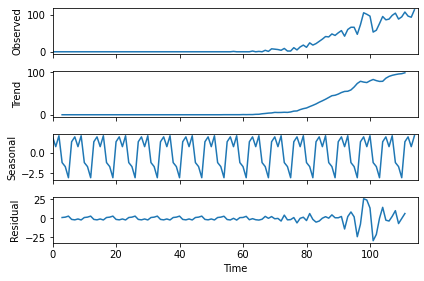

In [ ]:
print('Decomposition of RUSSIA_FPD')
fig=sm.tsa.seasonal_decompose(RUSSIA_FPD.y.values,freq=7).plot()

Decomposition of RUSSIA_C


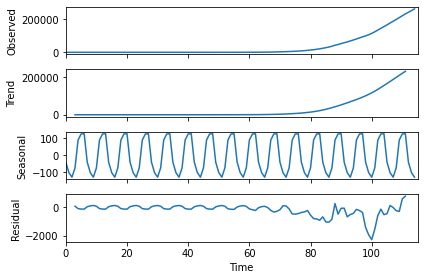

In [ ]:
print('Decomposition of RUSSIA_C')
fig=sm.tsa.seasonal_decompose(RUSSIA_C.y.values,freq=7).plot()

Decomposition of RUSSIA_F


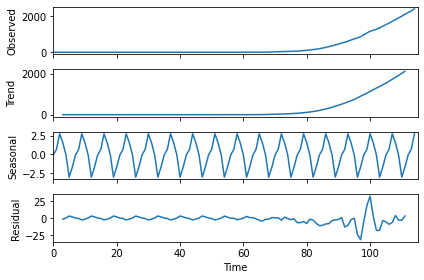

In [ ]:
print('Decomposition of RUSSIA_F')
fig=sm.tsa.seasonal_decompose(RUSSIA_F.y.values,freq=7).plot()

Проверим ряды на стационарность, используя тест Дики-Фуллера.

Проверку будем осуществлять следующим образом: 

если Test Statistic < Critical value[5%] => единичных корней нет и ряд стационарен

в пртивном случае необходимо продиффиринцировать ряд и сделать проверку заново.

In [ ]:
print('Test: RUSSIA_CPD')
stationarity(RUSSIA_CPD.y.values)

Test: RUSSIA_CPD
Results of Dickey-Fuller Test:
Test Statistic                   1.447087
p-value                          0.997318
#Lags Used                      11.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


In [ ]:
print('Test: RUSSIA_FPD')
stationarity(RUSSIA_FPD.y.values)

Test: RUSSIA_FPD
Results of Dickey-Fuller Test:
Test Statistic                   0.572733
p-value                          0.986924
#Lags Used                      13.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [ ]:
print('Test: RUSSIA_C')
stationarity(RUSSIA_C.y.values)

Test: RUSSIA_C
Results of Dickey-Fuller Test:
Test Statistic                  -4.260927
p-value                          0.000519
#Lags Used                      13.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [ ]:
print('Test: RUSSIA_F')
stationarity(RUSSIA_F.y.values)

Test: RUSSIA_F
Results of Dickey-Fuller Test:
Test Statistic                  -2.142223
p-value                          0.227879
#Lags Used                       9.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


Проведём анализ теста: 

- ряды RUSSIA_CPD,RUSSIA_FPD,RUSSIA_F являются стационарными => d = 0

- ряд RUSSIA_С является не является стационарным => необходимо диффиринцировать (d!=0) 

Построим графики автокорреляции, частичной корреляции из которых будем опрределять параметры p and q.

ACF and PACF for RUSSIA_CPD


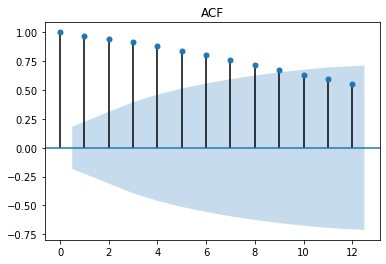

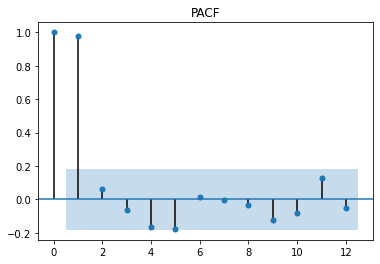

In [ ]:
print('ACF and PACF for RUSSIA_CPD')
corr(RUSSIA_CPD.y.values)

ACF and PACF for RUSSIA_FPD


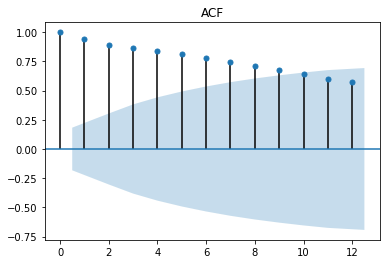

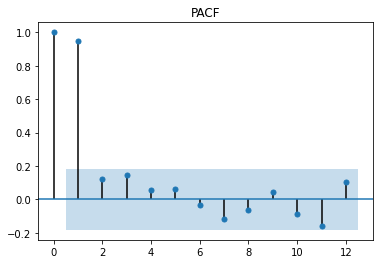

In [ ]:
print('ACF and PACF for RUSSIA_FPD')
corr(RUSSIA_FPD.y.values)

ACF and PACF for RUSSIA_C


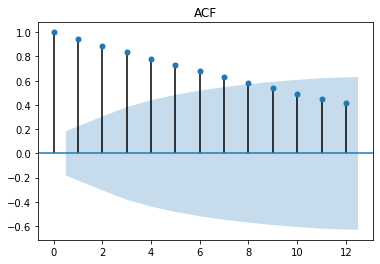

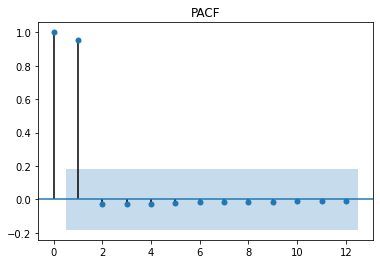

In [ ]:
print('ACF and PACF for RUSSIA_C')
corr(RUSSIA_C.y.values)

ACF and PACF for RUSSIA_F


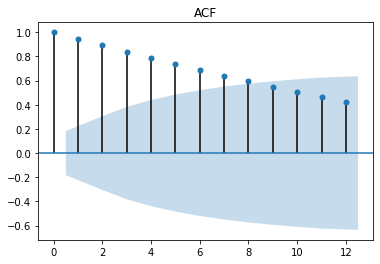

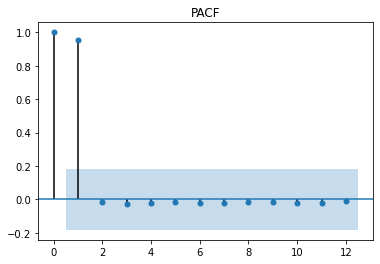

In [ ]:
print('ACF and PACF for RUSSIA_F')
corr(RUSSIA_F.y.values)

Определим кол-во сильно выступающих лагов. Почти для всех графиков значения p and q будут следующими:

- p = 9

- q = 2

Выполним прогноз для России, используя модель Arima.

Будем предсказывать на 3,6,9,12 и 15 дней соответственно.

In [ ]:
#forecast_RUSSIA_FPD_arima, mae_RUSSIA_FPD_arima, mape_RUSSIA_FPD_arima, test_df_RUSSIA_FPD = arima(df = RUSSIA_FPD,windows = [0.98,0.95,0.93,0.90,0.87])

In [ ]:
forecast_RUSSIA_CPD_arima, mae_RUSSIA_CPD_arima, mape_RUSSIA_CPD_arima, test_df_RUSSIA_CPD = arima(df = RUSSIA_CPD.y.values,windows = [0.98,0.95,0.93,0.90,0.87])


Mean absolute error: 1105.750956
Mean absolute percent error: 0.109707
Mean absolute error: 1354.566208
Mean absolute percent error: 0.131398
Mean absolute error: 2551.834689
Mean absolute percent error: 0.241695
Mean absolute error: 2949.279612
Mean absolute percent error: 0.279411
Mean absolute error: 1798.805153
Mean absolute percent error: 0.170386


In [ ]:
forecast_RUSSIA_C_arima, mae_RUSSIA_C_arima, mape_RUSSIA_C_arima, test_df_RUSSIA_C = arima(df = RUSSIA_C.y.values,windows = [0.98,0.95,0.93,0.90,0.87])

Mean absolute error: 2634.376783
Mean absolute percent error: 0.010297
Mean absolute error: 871.553023
Mean absolute percent error: 0.003589
Mean absolute error: 4300.967901
Mean absolute percent error: 0.017548
Mean absolute error: 7043.355938
Mean absolute percent error: 0.031713
Mean absolute error: 22452.142975
Mean absolute percent error: 0.108543


In [ ]:
forecast_RUSSIA_F_arima, mae_RUSSIA_F_arima, mape_RUSSIA_F_arima, test_df_RUSSIA_F = arima(df = RUSSIA_F.y.values,windows = [0.98,0.95,0.93,0.90,0.87])

Mean absolute error: 21.567571
Mean absolute percent error: 0.009318
Mean absolute error: 14.896556
Mean absolute percent error: 0.006698
Mean absolute error: 108.387958
Mean absolute percent error: 0.051467
Mean absolute error: 12.987313
Mean absolute percent error: 0.007612
Mean absolute error: 283.298482
Mean absolute percent error: 0.145662


Теперь перейдём к анализу рядов total. Также разложим их на составляющие.

Decomposition of TOTAL_CPD


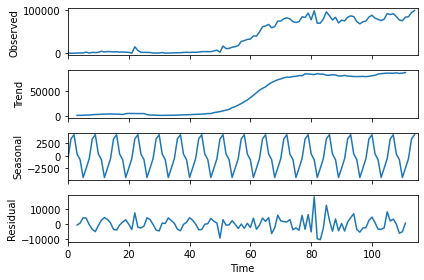

In [ ]:
print('Decomposition of TOTAL_CPD')
fig=sm.tsa.seasonal_decompose(TOTAL_CPD.y.values,freq=7).plot()

Decomposition of TOTAL_FPD


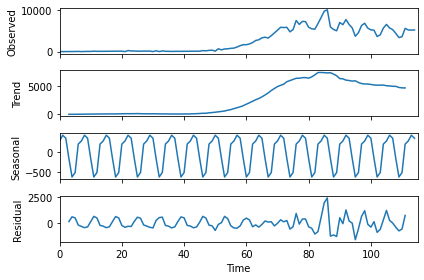

In [ ]:
print('Decomposition of TOTAL_FPD')
fig=sm.tsa.seasonal_decompose(TOTAL_FPD.y.values,freq=7).plot()

Decomposition of TOTAL_C


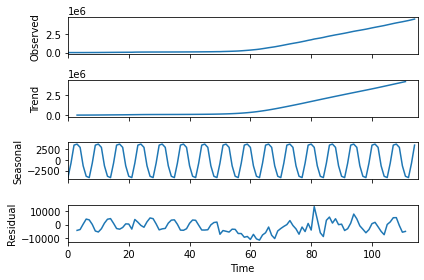

In [ ]:
print('Decomposition of TOTAL_C')
fig=sm.tsa.seasonal_decompose(TOTAL_C.y.values,freq=7).plot()

Decomposition of TOTAL_F


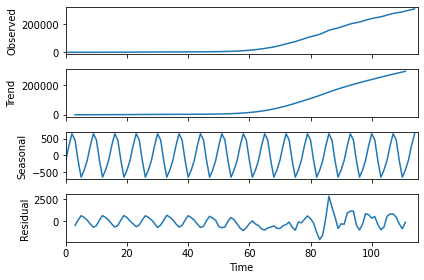

In [ ]:
print('Decomposition of TOTAL_F')
fig=sm.tsa.seasonal_decompose(TOTAL_F.y.values,freq=7).plot()

Проверим ряды на стационарность, используя тест Дики-Фуллера.

In [ ]:
print('Test: TOTAL_CPD')
stationarity(TOTAL_CPD.y.values)

Test: TOTAL_CPD
Results of Dickey-Fuller Test:
Test Statistic                  -0.955213
p-value                          0.769247
#Lags Used                      11.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


In [ ]:
print('Test: TOTAL_FPD')
stationarity(TOTAL_FPD.y.values)

Test: TOTAL_FPD
Results of Dickey-Fuller Test:
Test Statistic                  -1.168983
p-value                          0.686794
#Lags Used                       8.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


In [ ]:
print('Test: TOTAL_C')
stationarity(TOTAL_C.y.values)

Test: TOTAL_C
Results of Dickey-Fuller Test:
Test Statistic                   1.198526
p-value                          0.995976
#Lags Used                      12.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


In [ ]:
print('Test: TOTAL_F')
stationarity(TOTAL_F.y.values)

Test: TOTAL_F
Results of Dickey-Fuller Test:
Test Statistic                  -0.386553
p-value                          0.912320
#Lags Used                       9.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


Проведём анализ теста: 

- ряды TOTAL_CPD,TOTAL_FPD,TOTAL_F, TOTAL_С являются стационарными => d = 0 и модель будет тогда ARMA

Теперь построим графики автокорреляции и частичной корреляции для всех стран.

ACF and PACF for TOTAL_CPD


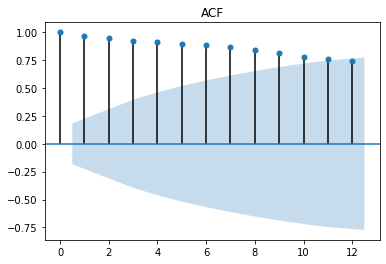

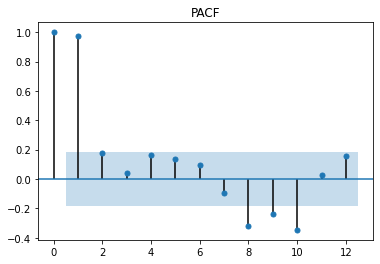

In [ ]:
print('ACF and PACF for TOTAL_CPD')
corr(TOTAL_CPD.y.values)

ACF and PACF for TOTAL_FPD


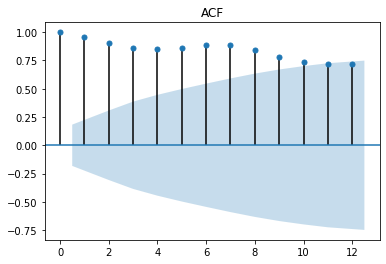

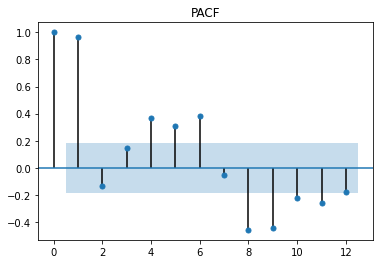

In [ ]:
print('ACF and PACF for TOTAL_FPD')
corr(TOTAL_FPD.y.values)

ACF and PACF for TOTAL_C


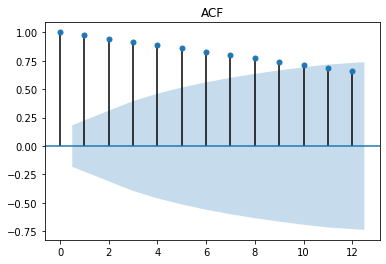

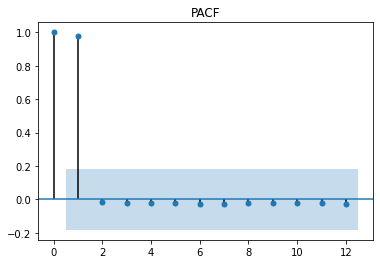

In [ ]:
print('ACF and PACF for TOTAL_C')
corr(TOTAL_C.y.values)

ACF and PACF for TOTAL_F


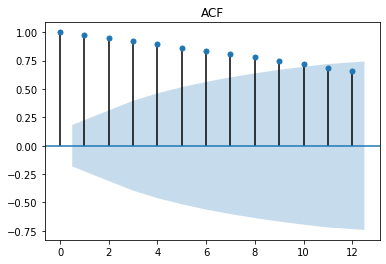

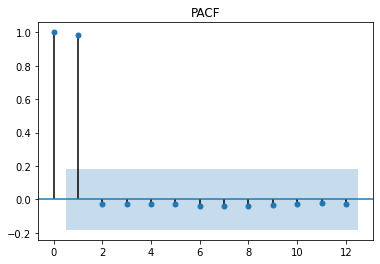

In [ ]:
print('ACF and PACF for TOTAL_F')
corr(TOTAL_F.y.values)

Определим кол-во сильно выступающих лагов. Почти для всех графиков значения p and q будут следующими:

- p = 10

- q = 2

Исключения составят: TOTAL_FPD , TOTAL_CPD, где значение q будет равно 4.

Выполним прогноз для всех стран, используя модель Arima.

Будем предсказывать на 3,6,9,12 и 15 дней соответственно.

In [ ]:
forecast_TOTAL_CPD_arima, mae_TOTAL_CPD_arima, mape_TOTAL_CPD_arima, test_df_TOTAL_CPD = arima(df = TOTAL_CPD.y.values,windows = [0.98,0.95,0.93,0.90,0.87])

Mean absolute error: 8219.630966
Mean absolute percent error: 0.084230
Mean absolute error: 7185.858202
Mean absolute percent error: 0.087296
Mean absolute error: 11027.776357
Mean absolute percent error: 0.130446
Mean absolute error: 4082.648891
Mean absolute percent error: 0.047605
Mean absolute error: 9866.522360
Mean absolute percent error: 0.111627


In [ ]:
forecast_TOTAL_FPD_arima, mae_TOTAL_FPD_arima, mape_TOTAL_FPD_arima, test_df_TOTAL_FPD = arima(df = TOTAL_FPD.y.values,windows = [0.98,0.95,0.93,0.90,0.87])

Mean absolute error: 545.321715
Mean absolute percent error: 0.104355
Mean absolute error: 535.008629
Mean absolute percent error: 0.122210
Mean absolute error: 459.848808
Mean absolute percent error: 0.098718
Mean absolute error: 991.167472
Mean absolute percent error: 0.188877
Mean absolute error: 2573.652034
Mean absolute percent error: 0.513726


In [ ]:
forecast_TOTAL_C_arima, mae_TOTAL_C_arima, mape_TOTAL_C_arima, test_df_TOTAL_C = arima(df = TOTAL_C.y.values,windows = [0.98,0.95,0.93,0.90,0.87])

Mean absolute error: 8777.500529
Mean absolute percent error: 0.001947
Mean absolute error: 22511.369965
Mean absolute percent error: 0.005189
Mean absolute error: 43879.295493
Mean absolute percent error: 0.010142
Mean absolute error: 13886.210632
Mean absolute percent error: 0.003360
Mean absolute error: 10658.023975
Mean absolute percent error: 0.002559


In [ ]:
forecast_TOTAL_F_arima, mae_TOTAL_F_arima, mape_TOTAL_F_arima, test_df_TOTAL_F = arima(df = TOTAL_F.y.values,windows = [0.98,0.95,0.93,0.90,0.87])

Mean absolute error: 1474.495829
Mean absolute percent error: 0.004867
Mean absolute error: 2646.248954
Mean absolute percent error: 0.008865
Mean absolute error: 2486.439252
Mean absolute percent error: 0.008359
Mean absolute error: 1370.090559
Mean absolute percent error: 0.004725
Mean absolute error: 3822.114273
Mean absolute percent error: 0.013239


# Model : Prophet

## Intro

Вторая модель - с использованием библиотеки Prophet. Концепция модели довольно проста. Она учитывает 3 компоненты: сезонность, тренд, аномальные дни и ошибку прогноза.

Перед построением нашей модели будем использовать кросс-валидацию для подбора следующих гиперпараметров:

а) 'seasonality_mode':('multiplicative','additive')

б) 'changepoint_range': [0.25, 0.5, 0.75,0.8,0.9,0.95]

После чего использовать наилучшие гиперпараметры в модели. 

***Описание функций:***

**transform_data(df)** - переименовывает колонки к нужному имени

**moving_average(df,windows)** - выводит скользящее среднее за n дней

**cross_validation(df,window)** - функция кросс валидации, используем для подбора гиперпараметров

**predict_prophet_new(df, windows,weekly_seasonality,seasonality_mode,changepoint_range,holidays,daily_seasonality )** - предсказание Prophet'a

Расскажу подробнее как устроена функция, предсказывающая времянной ряд.

1) Формируются массивы mae = [] and mape = []

2) Для каждого дня из массива windows вычисляется предсказание, считается mae and mape

3) Результат записывается в заданные массивы mae and mape

4) Функция возвращает прогноз и 2 массивы с ошибками ( mae , mape), вычисленными для каждого из дней в массиве windows

Нагляднее работа функции показана на схеме ниже.
<center>
<img src="https://ie.wampi.ru/2021/12/22/Untitled-15.jpg" alt="Untitled (15)" border="0",width = 500>

## Code

Выполним импорт необходимых библиотек для данной модели.

In [ ]:
from fbprophet.plot import add_changepoints_to_plot, plot_forecast_component
from fbprophet.plot import plot_yearly

from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from sklearn.model_selection import ParameterGrid
import holidays

from fbprophet import Prophet

from tqdm import tqdm


Импортируем праздники для более точного построения модели.

In [ ]:
dict_holydays = holidays.RU(years=(2018, 2021))
holidays_d = pd.DataFrame.from_dict(dict_holydays, orient='index').reset_index()
holidays_d = holidays_d.rename({'index':'ds', 0:'holiday'}, axis ='columns')
holidays_d['ds'] = pd.to_datetime(holidays_d.ds)
holidays_d = holidays_d.sort_values(by=['ds'])
holidays_d = holidays_d.reset_index(drop=True)
holidays_d.head(10)

ds                   holiday
0 2018-01-01                 Новый год
1 2018-01-02                 Новый год
2 2018-01-03                 Новый год
3 2018-01-04                 Новый год
4 2018-01-05                 Новый год
5 2018-01-06                 Новый год
6 2018-01-07    Православное Рождество
7 2018-01-08                 Новый год
8 2018-02-23  День защитника отечества
9 2018-03-08               День женщин

Напишем необходимые функции для построения модели.

In [ ]:
def transform_data(df):
  df.columns = ['ds', 'y']
  df.ds = pd.to_datetime(df.ds)
  return df


def moving_average(df,windows):
  df=df.sort_values(by=['ds'])
  df['moving_avg_users'] = df['y'].rolling(window=windows).mean()
  
  iplot([
      go.Scatter(x=df.tail(10000).ds , y=df.tail(10000).y, name='fact'),
      go.Scatter(x=df.tail(10000).ds , y=df.tail(10000).moving_avg_users, name='fact_moving_average_{}_days'.format(windows)) 
  ]);
  decomp = seasonal_decompose(df['y'],freq = windows)
  decomp.plot()
  plt.show()

def cross_validation(df,predictions):
  #print('Validaton:{}'.format(df))
  params_grid = {'seasonality_mode':('multiplicative','additive'),
                'changepoint_range': [0.25, 0.5, 0.75,0.8,0.9,0.95],
                }
                                    #50,75,100,150]
  grid = ParameterGrid(params_grid)
  cnt = 0
  for p in grid:
      cnt = cnt+1

  print('Total Possible Models',cnt)

  #predictions = 10
  train_df_loads =  df[:-predictions] 

  model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
  for p in tqdm(grid):
      test = pd.DataFrame()
      print(p)
      random.seed(0)
      train_model =Prophet(
                          seasonality_mode = p['seasonality_mode'],
                          changepoint_range = p['changepoint_range'],
                          daily_seasonality = True,
                          holidays=holidays_d, 
                          interval_width=0.95)


      train_model.fit(train_df_loads)
      train_forecast = train_model.make_future_dataframe(periods=predictions, freq='d')
      train_forecast = train_model.predict(train_forecast)
      test=train_forecast[['ds','yhat']]
      cmp_df = train_forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

      cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
      cmp_df['p'] = 100 * cmp_df['e']/cmp_df['y']


      abs_p = abs(cmp_df[-predictions:]['p'])
      abs_e = abs(cmp_df[-predictions:]['e'])
      yhat_low = cmp_df['yhat_lower']
      MAPE = np.mean(abs(cmp_df[-predictions:]['p']))
    
      model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
  parameters = model_parameters.sort_values(by=['MAPE'])
  parameters = parameters.reset_index(drop=True)
  a = parameters.head(10).Parameters
  for i,u in a.iteritems():
    print(u)  

In [ ]:
def predict_prophet_new(df,windows,weekly_seasonality,seasonality_mode,changepoint_range,holidays,daily_seasonality#,changepoint_prior_scale,n_changepoints
                    ):
  mae = []
  mape = []
  for window in tqdm(windows):
    m = Prophet(weekly_seasonality = weekly_seasonality, 
              daily_seasonality = daily_seasonality,
        seasonality_mode = seasonality_mode,
          changepoint_range =  changepoint_range,
              holidays = holidays
    )
    predictions_period = window
    train_df = df[:-predictions_period] 
    m.fit(train_df)
    future = m.make_future_dataframe(periods=predictions_period, freq='d')
    forecast = m.predict(future)

    new_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper','trend']].join(df.set_index('ds'))
    new_df['e'] = new_df['y'] - new_df['yhat']
    new_df['p'] = 100 * new_df['e']/new_df['y']

    abs_p = abs(new_df[-predictions_period:]['p'])
    abs_e = abs(new_df[-predictions_period:]['e'])
    mae.append(round(np.mean(abs(new_df[-predictions_period:]['e'])),0)) , mape.append(str(round(np.mean(abs(new_df[-predictions_period:]['p'])),2)))
    print ('MAPE - ошибка в процентах', str(round(np.mean(abs(new_df[-predictions_period:]['p'])),2))+'%')
  
    print ('MAE - абсолютная ошибка', round(np.mean(abs(new_df[-predictions_period:]['e'])),0))
  
  return forecast , mae,mape

Выполним подбор гиперпараметров для TOTAL.

In [ ]:
#cross_validation(TOTAL_CPD,20)
#cross_validation(TOTAL_FPD,20)
#cross_validation(TOTAL_C,20)
#cross_validation(TOTAL_F,20)

In [ ]:
windows = [3,6,9,12,15]

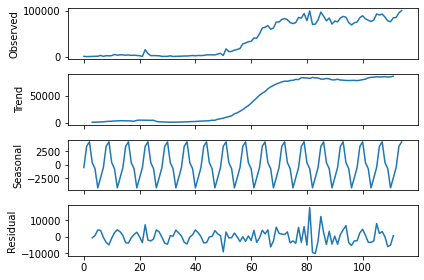

In [ ]:
moving_average(TOTAL_CPD,7)

Используя подобранные гиперпараметры, сделаем прогноз для TOTAL на 3 , 6 , 9 , 12 и 15 дней соответственно.

In [ ]:
forecast_TOTAL_CPD_prophet, mae_TOTAL_CPD_prophet, mape_TOTAL_CPD_prophet = predict_prophet_new(df=TOTAL_CPD,windows=windows,weekly_seasonality=True,seasonality_mode='multiplicative',changepoint_range = 0.95,holidays = holidays_d,daily_seasonality = False)
forecast_TOTAL_FPD_prophet, mae_TOTAL_FPD_prophet, mape_TOTAL_FPD_prophet = predict_prophet_new(df=TOTAL_FPD,windows=windows,weekly_seasonality=True,seasonality_mode='multiplicative',changepoint_range = 0.75,holidays = holidays_d,daily_seasonality = False)
forecast_TOTAL_C_prophet, mae_TOTAL_C_prophet, mape_TOTAL_C_prophet = predict_prophet_new(df=TOTAL_C,windows=windows,weekly_seasonality=True,seasonality_mode='multiplicative',changepoint_range = 0.75,holidays = holidays_d,daily_seasonality = False)
forecast_TOTAL_F_prophet, mae_TOTAL_F_prophet, mape_TOTAL_F_prophet = predict_prophet_new(df=TOTAL_F,windows=windows,weekly_seasonality=True,seasonality_mode='additive',changepoint_range = 0.95,holidays = holidays_d,daily_seasonality = False)


  0%|          | 0/5 [00:00<?, ?it/s]INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
 20%|██        | 1/5 [00:03<00:14,  3.58s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 15.74%
MAE - абсолютная ошибка 14541.0


 40%|████      | 2/5 [00:06<00:08,  2.94s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 18.49%
MAE - абсолютная ошибка 15701.0


 60%|██████    | 3/5 [00:08<00:05,  2.59s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 19.69%
MAE - абсолютная ошибка 17102.0


 80%|████████  | 4/5 [00:10<00:02,  2.40s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 18.5%
MAE - абсолютная ошибка 15856.0


100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


MAPE - ошибка в процентах 30.19%
MAE - абсолютная ошибка 25828.0


 20%|██        | 1/5 [00:02<00:08,  2.19s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 58.39%
MAE - абсолютная ошибка 3053.0


 40%|████      | 2/5 [00:04<00:06,  2.29s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 59.81%
MAE - абсолютная ошибка 2785.0


 60%|██████    | 3/5 [00:06<00:04,  2.27s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 65.2%
MAE - абсолютная ошибка 3139.0


 80%|████████  | 4/5 [00:08<00:02,  2.21s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 66.4%
MAE - абсолютная ошибка 3246.0


100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


MAPE - ошибка в процентах 83.64%
MAE - абсолютная ошибка 4048.0


 20%|██        | 1/5 [00:02<00:08,  2.16s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 0.88%
MAE - абсолютная ошибка 39196.0


 40%|████      | 2/5 [00:04<00:07,  2.35s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 0.8%
MAE - абсолютная ошибка 34898.0


 60%|██████    | 3/5 [00:06<00:04,  2.33s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 0.77%
MAE - абсолютная ошибка 32948.0


 80%|████████  | 4/5 [00:09<00:02,  2.32s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 0.58%
MAE - абсолютная ошибка 24308.0


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


MAPE - ошибка в процентах 0.46%
MAE - абсолютная ошибка 18284.0


 20%|██        | 1/5 [00:02<00:08,  2.20s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 0.13%
MAE - абсолютная ошибка 394.0


 40%|████      | 2/5 [00:04<00:07,  2.36s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 0.91%
MAE - абсолютная ошибка 2702.0


 60%|██████    | 3/5 [00:06<00:04,  2.31s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 0.45%
MAE - абсолютная ошибка 1302.0


 80%|████████  | 4/5 [00:09<00:02,  2.24s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 1.47%
MAE - абсолютная ошибка 4219.0


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]

MAPE - ошибка в процентах 1.55%
MAE - абсолютная ошибка 4422.0


Выполним валидацию отдельно для России.

In [ ]:
#cross_validation(RUSSIA_CPD,20)
#cross_validation(RUSSIA_FPD,20)
#cross_validation(RUSSIA_C,20)
#cross_validation(RUSSIA_F,20)

In [ ]:
windows = [3,6,9,12,15]

Сделаем прогноз для России на 3,6,9,12 и 15 дней соответветственно. И посчитаем выбранные метрики.

In [ ]:
forecast_RUSSIA_CPD_prophet, mae_RUSSIA_CPD_prophet, mape_RUSSIA_CPD_prophet = predict_prophet_new(df=RUSSIA_CPD,windows=windows,weekly_seasonality=True,seasonality_mode='additive',changepoint_range = 0.75,holidays = holidays_d,daily_seasonality = False)
forecast_RUSSIA_FPD_prophet, mae_RUSSIA_FPD_prophet, mape_RUSSIA_FPD_prophet = predict_prophet_new(df=RUSSIA_FPD,windows=windows,weekly_seasonality=True,seasonality_mode='additive',changepoint_range = 0.75,holidays = holidays_d,daily_seasonality = False)
forecast_RUSSIA_C_prophet, mae_RUSSIA_C_prophet, mape_RUSSIA_C_prophet = predict_prophet_new(df=RUSSIA_C,windows=windows,weekly_seasonality=True,seasonality_mode='additive',changepoint_range = 0.95,holidays = holidays_d,daily_seasonality = False)
forecast_RUSSIA_F_prophet, mae_RUSSIA_F_prophet, mape_RUSSIA_F_prophet = predict_prophet_new(df=RUSSIA_F,windows=windows,weekly_seasonality=True,seasonality_mode='multiplicative',changepoint_range = 0.9,holidays = holidays_d,daily_seasonality = False)


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 21.02%
MAE - абсолютная ошибка 2141.0


 40%|████      | 2/5 [00:04<00:06,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 13.13%
MAE - абсолютная ошибка 1355.0


 60%|██████    | 3/5 [00:06<00:04,  2.20s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 8.89%
MAE - абсолютная ошибка 937.0


 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 10.48%
MAE - абсолютная ошибка 1115.0


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


MAPE - ошибка в процентах 15.61%
MAE - абсолютная ошибка 1648.0


 20%|██        | 1/5 [00:02<00:08,  2.07s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 9.5%
MAE - абсолютная ошибка 9.0


 40%|████      | 2/5 [00:04<00:06,  2.10s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 7.85%
MAE - абсолютная ошибка 7.0


 60%|██████    | 3/5 [00:06<00:04,  2.17s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 6.82%
MAE - абсолютная ошибка 7.0


 80%|████████  | 4/5 [00:08<00:02,  2.14s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 6.49%
MAE - абсолютная ошибка 6.0


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


MAPE - ошибка в процентах 13.33%
MAE - абсолютная ошибка 10.0


 20%|██        | 1/5 [00:02<00:09,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 0.48%
MAE - абсолютная ошибка 1224.0


 40%|████      | 2/5 [00:04<00:06,  2.27s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 0.24%
MAE - абсолютная ошибка 574.0


 60%|██████    | 3/5 [00:07<00:04,  2.37s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 2.5%
MAE - абсолютная ошибка 5691.0


 80%|████████  | 4/5 [00:09<00:02,  2.34s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 10.83%
MAE - абсолютная ошибка 23435.0


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


MAPE - ошибка в процентах 14.86%
MAE - абсолютная ошибка 31034.0


 20%|██        | 1/5 [00:02<00:08,  2.12s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 2.65%
MAE - абсолютная ошибка 61.0


 40%|████      | 2/5 [00:04<00:06,  2.18s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 4.4%
MAE - абсолютная ошибка 95.0


 60%|██████    | 3/5 [00:06<00:04,  2.29s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 3.59%
MAE - абсолютная ошибка 76.0


 80%|████████  | 4/5 [00:08<00:02,  2.24s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE - ошибка в процентах 7.95%
MAE - абсолютная ошибка 157.0


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]

MAPE - ошибка в процентах 14.21%
MAE - абсолютная ошибка 263.0


# Functions for visualization

In [ ]:
def visualize_predictions(df,days,pred_arima,pred_prophet,title,xaxis_title,yaxis_title):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=days , y=df['y'].tail(10000), name='fact'))
  fig.add_trace(go.Scatter(x=days[100:] , y=pred_arima, name='predict_arima'))
  fig.add_trace(go.Scatter(x=days[100:] , y=pred_prophet, name='predict_prophet'))
  fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="{}".format(title),
                  xaxis_title="{}".format(xaxis_title),
                  yaxis_title="{}".format(yaxis_title),
                  margin=dict(l=0, r=0, t=30, b=0))
  fig.show()

def visualize_metrics(windows,mae_arima,mae_prophet,mape_arima,mape_prophet,title_mae,title_mape):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=windows , y=mae_arima, name='mae_arima',marker=dict(color='rgba(235,28,28,1)', size=12)))
  fig.add_trace(go.Scatter(x=windows , y=mae_prophet, name='mae_prophet', marker=dict(color='rgba(42,189,113,1)', size=12)))
  fig.update_layout(legend_orientation="h",
            legend=dict(x=.5, xanchor="center"),
            title="{}".format(title_mae),
            xaxis_title="days",
            yaxis_title="MAE error",
            margin=dict(l=0, r=0, t=30, b=0))
  fig.show()

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=windows , y=mape_arima, name='mape_arima',marker=dict(color='rgba(235,28,28,1)', size=12)))
  fig.add_trace(go.Scatter(x=windows , y=mape_prophet, name='mape_prophet', marker=dict(color='rgba(42,189,113,1)', size=12)))
  fig.update_layout(legend_orientation="h",
            legend=dict(x=.5, xanchor="center"),
            title="{}".format(title_mape),
            xaxis_title="days",
            yaxis_title="MAPE error",
            margin=dict(l=0, r=0, t=30, b=0))
  fig.show()


# Visualize predictions

Покажем на графиках как справились с предсказанием наши модели: 

по оси x - дни

по оси y - значения подтвержденных случаев заболевания/смертей 

И проанализируем полученные значения.

In [ ]:
days = np.array([x for x in range(115)])
days[100:]

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114])

In [ ]:
visualize_predictions(TOTAL_CPD,days,forecast_TOTAL_CPD_arima,forecast_TOTAL_CPD_prophet['yhat'].tail(15),title = 'TOTAL Confirmed Cases per day',xaxis_title = 'days',yaxis_title = 'Confirmed Cases per day')
visualize_predictions(TOTAL_FPD,days,forecast_TOTAL_FPD_arima,forecast_TOTAL_FPD_prophet['yhat'].tail(15),title = 'TOTAL Fatalities per day',xaxis_title = 'days',yaxis_title = 'Fatalities per day')
visualize_predictions(TOTAL_C,days,forecast_TOTAL_C_arima,forecast_TOTAL_C_prophet['yhat'].tail(15),title = 'TOTAL Confirmed Cases',xaxis_title = 'days',yaxis_title = 'Confirmed Cases')
visualize_predictions(TOTAL_F,days,forecast_TOTAL_F_arima,forecast_TOTAL_F_prophet['yhat'].tail(15),title = 'TOTAL Fatalities',xaxis_title = 'days',yaxis_title = 'Fatalities')

In [ ]:
visualize_predictions(RUSSIA_CPD,days,forecast_RUSSIA_CPD_arima,forecast_RUSSIA_CPD_prophet['yhat'].tail(15),title = 'RUSSIA Confirmed Cases per day',xaxis_title = 'days',yaxis_title = 'Confirmed Cases per day')
#visualize_predictions(RUSSIA_FPD,test_df_RUSSIA_FPD,forecast_RUSSIA_FPD_arima,forecast_RUSSIA_FPD_prophet['yhat'].tail(15),title = 'RUSSIA Fatalities per day',xaxis_title = 'days',yaxis_title = 'Fatalities per day')
visualize_predictions(RUSSIA_C,days,forecast_RUSSIA_C_arima,forecast_RUSSIA_C_prophet['yhat'].tail(15),title = 'RUSSIA Confirmed Cases',xaxis_title = 'days',yaxis_title = 'Confirmed Cases')
visualize_predictions(RUSSIA_F,days,forecast_RUSSIA_F_arima,forecast_RUSSIA_F_prophet['yhat'].tail(15),title = 'RUSSIA Fatalities',xaxis_title = 'days',yaxis_title = 'Fatalities')

# Сomparison of models by metrics

Выполним сравнение предсказаний моделей по выбранным метрикам: MAE и MAPE.

По оси x будем откладывать временной интервал: 3,6,9,12 и 15 дней соответственно.

По оси y откладываем MAE or MAPE.

Далее проанализируем полученные результаты.

In [ ]:
windows = [3,6,9,12,15]

In [ ]:
visualize_metrics(windows,mae_RUSSIA_CPD_arima,mae_RUSSIA_CPD_prophet,mape_RUSSIA_CPD_arima,mape_RUSSIA_CPD_prophet,'Error graph of MAE by RUSSIA_CPD','Error graph of MAPE by RUSSIA_CPD')

In [ ]:
visualize_metrics(windows,mae_RUSSIA_C_arima,mae_RUSSIA_C_prophet,mape_RUSSIA_C_arima,mape_RUSSIA_C_prophet,'Error graph of MAE by RUSSIA_C','Error graph of MAPE by RUSSIA_C')

In [ ]:
visualize_metrics(windows,mae_RUSSIA_F_arima,mae_RUSSIA_F_prophet,mape_RUSSIA_F_arima,mape_RUSSIA_F_prophet,'Error graph of MAE by RUSSIA_F','Error graph of MAPE by RUSSIA_F')

In [ ]:
visualize_metrics(windows,mae_TOTAL_C_arima,mae_TOTAL_C_prophet,mape_TOTAL_C_arima,mape_TOTAL_C_prophet,'Error graph of MAE by TOTAL_C','Error graph of MAPE by TOTAL_C')

In [ ]:
visualize_metrics(windows,mae_TOTAL_F_arima,mae_TOTAL_F_prophet,mape_TOTAL_F_arima,mape_TOTAL_F_prophet,'Error graph of MAE by TOTAL_F','Error graph of MAPE by TOTAL_F')

In [ ]:
visualize_metrics(windows,mae_TOTAL_CPD_arima,mae_TOTAL_CPD_prophet,mape_TOTAL_CPD_arima,mape_TOTAL_CPD_prophet,'Error graph of MAE by TOTAL_CPD','Error graph of MAPE by TOTAL_CPD')

In [ ]:
visualize_metrics(windows,mae_TOTAL_FPD_arima,mae_TOTAL_FPD_prophet,mape_TOTAL_FPD_arima,mape_TOTAL_FPD_prophet,'Error graph of MAE by TOTAL_FPD','Error graph of MAPE by TOTAL_FPD')

# Conclussion

Проанализировав графики, можно сделать следующие выводы
о моделях: 

При прогнозировании рядов, которые имели приближенную линейную зависимость (TOTAL_C, RUSSIA_C), обе модели справились довольно хорошо. Ошибка MAPE для TOTAL_C не превышала 1% при прогнозе до 15 дней. Однако при прогнозировании RUSSIA_C значение ошибки доходило до 15% у модели Prophet. Ошибка MAE для TOTAL_С достигала максимума у модели Arima и составила ~45к, т.е. в среднем модель ошибается на ~45к человек из ~4млн. Для TOTAL_C максимум MAE был у модели Prophet и составил ~30к. Стоит отметить, что для данных двух временных рядов модель предсказания Arima справилась с задачей чуть лучше.

Аналогичные выводы можно сделать для TOTAL_F, RUSSIA _F (эти графики имеют линейную зависимость). Ошибки на feature TOTAL_F не были высоки (MAPE не больше 2%, при MAE ~4.5к), на признаке RUSSIA _F MAPE и MAE, как ожидалось, оказались выше (MAPE ~14%, MAE ~ 250). В данном случае обе модели имели примерно одинаковые ошибки на горизонте 15 дней, из чего можно сделать вывод о том, что при прогнозировании TOTAL_F and RUSSIA _F модели оказались равными.

При прогнозировании рядов, не имеющих выраженных линейную зависимость (TOTAL_CPD, RUSSIA_CPD ,TOTAL_FPD), predict моделей ожидаемо оказался хуже. Так, модель Prophet TOTAL_CPD на 15 дневном прогнозе завышала результаты, а модель Arima, наоборот, занижала (max MAPE Prophet ~ 30%, a max MAPE Arima ~14%). В данном случае для TOTAL_CPD предсказания Arimы были лучше. Однако при предсказания ряда для RUSSIA_CPD модель Prophet справилась лучше (max MAPE Prophet ~ 15%, a max MAPE Arima ~28% )

Также хочу отметить тот факт, что для прогноза было взяты данные всего за 4 месяца, что могло привести к недообучаемости у моделей